Starting Portfolio Value: 100000.00
Final Portfolio Value: 107174.31
pct_chg=7.17%


<IPython.core.display.Javascript object>


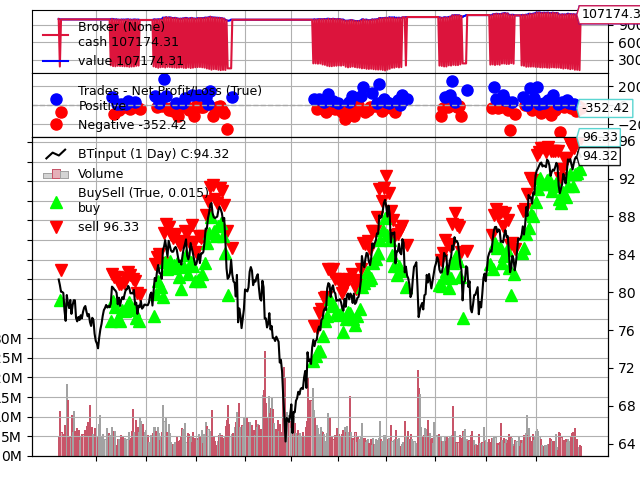

In [4]:
# Jordan Salvatore / jmsalvatore@wpi.edu / December 2020

import os
path = 'C:/Users/Jordan/Desktop'
os.chdir(path)

import backtrader as bt

import csv
from matplotlib import warnings
import matplotlib

#if os.path.exists("result.csv"):
#    os.remove("result.csv")
#else:
#    print("The file does not exist")

import pandas as pd
import numpy as np
#from finta import TA

# Add Data
import yfinance as yf

from datetime import datetime
from backtrader.feeds import GenericCSVData

class GenericCSV_Indicators(GenericCSVData):
    # Add a predicted line to the inherited ones from the base class
    lines = ('Slopes','NextDayDecrease',)
    # Add the parameter to the parameters inherited from the base class
    params = (('Slopes', 10),('NextDayDecrease', 11),)
    

def get_data_with_indicators(filename): 
    data = GenericCSV_Indicators(
    dataname = filename,
    #simulation period
    fromdate = datetime(2018, 3, 15),
    todate = datetime(2019, 12, 31),
    nullvalue=0.0,
    dtformat=('%Y-%m-%d'),
    datetime=0,
    high=2,
    low=3,
    open=1,
    close=4,
    volume=6,
    openinterest=-1,
    #extra indicators
    Slopes=10,
    NextDayDecrease=11

    )
    return data	

class LSTMStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        #print('%s, %s' % (dt.isoformat(), txt))
        return('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):


        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.order = None
        self.inmarket = False
        self.inmarketdataindex = None
        self.firsttradedate = None
        self.buyprice = 0.00
        self.sellprice = 0.00
        self.size = 0.00
        self.filename = "result.csv"
        self.W = []
        self.L = []

    def next(self):

        # Check for open orders
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # We are not in the market, look for a signal to OPEN trades
            #If the slope of the EMA of the last 7 days is positive
            if self.datas[0].Slopes[0] > 0:
                self.buy()
        else:
            # We are already in the market, look for a signal to CLOSE trades
			#If the LSTM model predicts a drop in price 2 days in a row
            if self.datas[0].NextDayDecrease[0] == 1:
                self.order = self.close()
           
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enougth cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
                with open(self.filename, 'a') as csvfile:
                    csvwriter = csv.writer(csvfile)
                    # csvwriter.writerow(self.fields)
                    row = [[self.log('BUY EXECUTED, %.2f' %
                                     order.executed.price)]]
                    csvwriter.writerows(row)
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, %.2f' % order.executed.price)
                with open(self.filename, 'a') as csvfile:
                    csvwriter = csv.writer(csvfile)
                    # csvwriter.writerow(self.fields)
                    row = [[self.log('SELL EXECUTED, %.2f' %
                                     order.executed.price)]]
                    csvwriter.writerows(row)
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        if trade.pnl > 0:
            self.W.append(trade.pnl)
        elif trade.pnl <= 0:
            self.L.append(trade.pnl)

        # expectun = expectunity(self.W, self.L, 500)
        # self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f EXPECTUNITY %.2f WINS %d LOSSES %d' %
        #          (trade.pnl, trade.pnlcomm, expectun, len(self.W), len(self.L)))


def backtest():
    #Fix stake
    stake = 1000

    cerebro = bt.Cerebro()

    cerebro.broker.setcash(100000.0)
    cerebro.addstrategy(LSTMStrategy)
    
    data = get_data_with_indicators(filename='BTinput.csv')

    # Put Data into Cerebro   
    cerebro.adddata(data)
    
    #Default position size
    cerebro.addsizer(bt.sizers.SizerFix, stake=stake)

    startValue = cerebro.broker.getvalue()
    print('Starting Portfolio Value: %.2f' % startValue)

    cerebro.run()

    endValue = cerebro.broker.getvalue()
    print('Final Portfolio Value: %.2f' % endValue)

    perc = (endValue - startValue) / startValue * 100

    # Print percentage change in the value
    print("pct_chg=%.2f%%" % (perc))
    cerebro.plot()


# if __name__ == "__main__":
#     backtest()

# standard expectunity formula
def expectancy(wins, losses):

    try: 
        AW = sum(wins)/len(wins)
        PW = len(wins)/(len(wins) + len(losses))
 
        AL = sum(losses)/len(losses)
        PL = len(losses)/(len(wins) + len(losses))

        return (AW * PW + AL * PL)/abs(AL)
    
    except ZeroDivisionError:
        return 0

def expectunity(wins, losses, strat_cal_days):

    try:
        # Calculate the opportunity value
        num_trades = len(wins) + len(losses)
        #strat_cal_days = len(trans)
        strat_cal_days= max(strat_cal_days,1)  # avoid divide by zero
        opportunities = num_trades * 365/strat_cal_days
    
        return expectancy(wins, losses) * opportunities
    
    except ZeroDivisionError:
        return 0

backtest()
